In [1]:
# Importation des modules et librairies nécessaires:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import sklearn
import os


# Cas d'étude :

        Dans ce challenge, on traitera différents modèles de régressions visant à prédire la demande de vélos en libre-service à Londres à partir de données météorologiques, calendaires et temporelles. Le travail a consisté à effectuer un preprocessing complet incluant la gestion des valeurs manquantes, l’encodage, le scaling et la création de variables dérivées comme les composantes sinusoïdales de l’heure et du mois. Plusieurs modèles ont été testés, puis optimisés. Le modèle final, encapsulé dans une pipeline complète, permet désormais d’estimer avec précision le nombre de vélos loués pour de nouvelles observations données.

In [2]:
# Lecture de la base de données :

df= pd.read_csv('london_merged.csv')

## 1- Preprocessing de la données :

        On commence par une analyse globale de notre data set afin de voir quels opérations de cleaning seront necéssaires

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [4]:
df.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000


In [5]:
df.duplicated().sum()

np.int64(0)

In [6]:
df.isnull().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

In [7]:
# Transformation de la colonne du temps :

df["timestamp"]=pd.to_datetime(df["timestamp"])

In [8]:
# Extraction des heures et des mois de la colonne date pour une meilleures utilisation de l'information temporelle :

df["hour"]=df['timestamp'].dt.hour
df['month'] = df['timestamp'].dt.month

# Encodage cyclique des heures (i.e: le modèle saura reconnaitre par exemple que 23h et 00h se succèdent) :

df['sin_hour']=np.sin(2*np.pi*df['hour']/24)
df['cos_hour']=np.cos(2*np.pi*df['hour']/24)

# Encodage cyclique des mois (i.e: le modèle saura reconnaitre par exemple que décembre et janvier se succèdent) :

df['sin_month']=np.sin(2*np.pi*df['month']/12)
df['cos_month']=np.cos(2*np.pi*df['month']/12)


In [9]:
# Suppression des colonnes originale du temps après modifications :

df_new=df.drop(['timestamp','hour','month'],axis=1)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cnt           17414 non-null  int64  
 1   t1            17414 non-null  float64
 2   t2            17414 non-null  float64
 3   hum           17414 non-null  float64
 4   wind_speed    17414 non-null  float64
 5   weather_code  17414 non-null  float64
 6   is_holiday    17414 non-null  float64
 7   is_weekend    17414 non-null  float64
 8   season        17414 non-null  float64
 9   sin_hour      17414 non-null  float64
 10  cos_hour      17414 non-null  float64
 11  sin_month     17414 non-null  float64
 12  cos_month     17414 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.7 MB


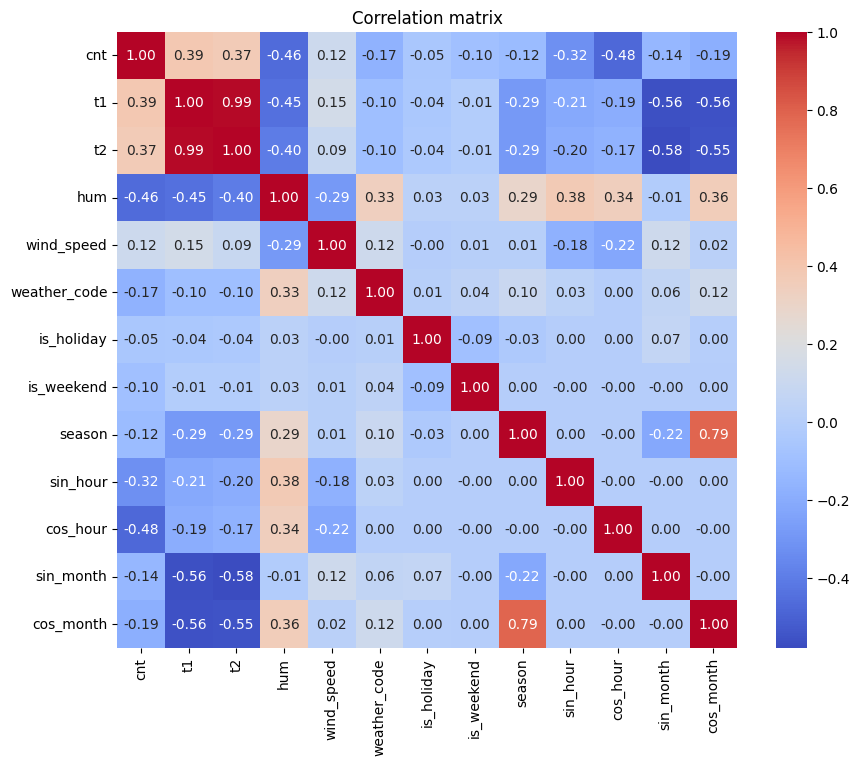

In [10]:
# Detection de possible multicolinéarité entre les variables :

corr_mat=df_new.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_mat,annot=True,cmap='coolwarm',fmt=".2f")
plt.title("Correlation matrix")
plt.show()

In [11]:
# Suppression de la colonne 't2' (température ressentie) qui est fortement corrélée avec la variable 't1' :

df_new.drop(columns='t2',inplace=True)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cnt           17414 non-null  int64  
 1   t1            17414 non-null  float64
 2   hum           17414 non-null  float64
 3   wind_speed    17414 non-null  float64
 4   weather_code  17414 non-null  float64
 5   is_holiday    17414 non-null  float64
 6   is_weekend    17414 non-null  float64
 7   season        17414 non-null  float64
 8   sin_hour      17414 non-null  float64
 9   cos_hour      17414 non-null  float64
 10  sin_month     17414 non-null  float64
 11  cos_month     17414 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 1.6 MB


In [12]:
# Décomposition chronologique de la data : 80 % pour l'entrainement du modèle et 20 % pour le test

train_size=int(len(df_new)*0.8)
train=df_new.iloc[:train_size].copy()
test=df_new.iloc[train_size:].copy()

x_train=train.drop(columns='cnt')
y_train=train['cnt']

x_test=test.drop(columns='cnt')
y_test=test['cnt']

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# Création d'une pipeline pour le preprocessing des données, notamment pour la standardisation et l'imputation des valeurs manquantes :

Col=x_train.columns

pipeline=Pipeline([
    ('scaler',StandardScaler()),
    ('imputer',SimpleImputer(strategy='median'))
])

preprocessor=ColumnTransformer([
    ('pip',pipeline,Col)
])


## 2- Evalution des différents modèles de regression :

Dans un premier temps, on évaluera des modèles de regression grâce à 2 métriques qui sont le RMSE et le R2 score afin de trouver le meilleur modèle qui fittera notre données.

In [14]:
from sklearn.metrics import mean_squared_error,r2_score

# Création d'une pipeline pour un modèle de regression linéaire :

full_pipeline_linreg=Pipeline([
    ('preporc',preprocessor),
    ('regressor', LinearRegression())
])

full_pipeline_linreg.fit(x_train,y_train)
linreg_pred=full_pipeline_linreg.predict(x_test)

# Evaluation du modèle de regression linéraire à l'aide de 2 principales métriques (RMSE et R2 score) :

lin_MSE=mean_squared_error(y_test,linreg_pred)
lin_RMSE=np.sqrt(lin_MSE)
r2=r2_score(y_test,linreg_pred)
print("RMSE :",lin_RMSE)
print("R2 :",r2)

RMSE : 863.1662786597924
R2 : 0.4149810768753843


In [15]:
# Création d'une pipeline pour un modèle de regression de forêt aléatoire :

full_pip_rm=Pipeline([
    ('preporc',preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

full_pip_rm.fit(x_train,y_train)
rm_pred=full_pip_rm.predict(x_test)

# Evaluation du modèle de regression de forêt aléatoire à l'aide de 2 principales métriques (RMSE et R2 score) :

rm_MSE=mean_squared_error(y_test,rm_pred)
rm_RMSE=np.sqrt(rm_MSE)
r2_rm=r2_score(y_test,rm_pred)
print("RMSE :",rm_RMSE)
print("R2 :",r2_rm)


RMSE : 317.2754809576438
R2 : 0.9209587125604263


In [16]:
# Création d'une pipeline pour un modèle de regression d'arbre de décision :

full_pip_dtr=Pipeline([
    ('preporc',preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

full_pip_dtr.fit(x_train,y_train)
dtr_pred=full_pip_dtr.predict(x_test)

# Evaluation du modèle de regression d'arbre de décision à l'aide de 2 principales métriques (RMSE et R2 score) :

dtr_MSE=mean_squared_error(y_test,dtr_pred)
dtr_RMSE=np.sqrt(dtr_MSE)
r2_dtr=r2_score(y_test,dtr_pred)
print("RMSE :",dtr_RMSE)
print("R2 :",r2_dtr)


RMSE : 437.1720590360705
R2 : 0.8499328006679921


In [17]:
# Création d'une pipeline pour un modèle de régression à vecteurs de support :

full_pip_svr=Pipeline([
    ('preporc',preprocessor),
    ('regressor', SVR(kernel='linear'))
])

full_pip_svr.fit(x_train,y_train)
svr_pred=full_pip_svr.predict(x_test)

# Evaluation du modèle de regression à vecteurs de support à l'aide de 2 principales métriques (RMSE et R2 score) :

svr_MSE=mean_squared_error(y_test,svr_pred)
svr_RMSE=np.sqrt(svr_MSE)
r2_svr=r2_score(y_test,svr_pred)
print("RMSE :",svr_RMSE)
print("R2 :",r2_svr)


RMSE : 960.9044343567028
R2 : 0.27499437118629333


A travers les résultats obtenus par les métriques de chaque modèle, on remarque que le modèle du Random forest est celui qui nous donne la meilleure précision avec un R2 score de 92 %.

Pour confirmer ce résultat, on effectuera une cross validation sur ce modèle qui elle calculera la précision sur plusieurs ensembles (echantillons) de notre données.

In [18]:
# Cross validation on Random Forest model:

from sklearn.model_selection import cross_val_score

X=df_new.drop(columns=['cnt'])
Y=df_new["cnt"]

rm_MSE_score=cross_val_score(full_pip_rm,X,Y,scoring='neg_mean_squared_error',cv=10)
rm_RMSE_score=np.mean(np.sqrt(-rm_MSE_score))

rm_score=cross_val_score(full_pip_rm,X,Y,scoring='r2',cv=10)
rm_R2_score=np.mean(rm_score)

print("Mean RMSE is :",rm_RMSE_score)
print("Mean R2 is :",rm_R2_score)

Mean RMSE is : 278.8227688841915
Mean R2 is : 0.9215324292256879


Les résultats de la cross validation confirment l'excellente précision de notre Random forest, essayons maintenant de trouver les meilleures associations possibles des hyper paramètres de notre Random forest model en utilisant les 2 principales techniques de fine-tuning :

## 3- Fine-Tuning models :

In [ ]:
# Fine-tuning on Random Forest model :

from sklearn.model_selection import GridSearchCV

# Selection de quelques paramètres importants pour le Random Forest model :

par_grid=[
    {   
        'regressor__n_estimators': [200,400,600],
        'regressor__max_depth': [10,15,20,None],
        'regressor__max_features': [None, "sqrt", 0.5],
        'regressor__min_samples_split' : [2,5,10],
        'regressor__min_samples_leaf': [1,2,4],
    } 
]

# Fine-Tuning avec l'utilisation de GridSearchCV :

grid = GridSearchCV(
    estimator=full_pip_rm,
    param_grid=par_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,            
    verbose=2,
    refit=True            
)

grid.fit(x_train,y_train)
Best_parameters=grid.best_params_
Best_score=grid.best_score_
print("Les meilleurs paramètres sont :", Best_parameters)
print("Le score R2 associé est :", Best_score)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Les meilleurs paramètres sont : {'regressor__max_depth': 20, 'regressor__max_features': None, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200}
Le score R2 associé est : 0.9087305258703339


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Fine-Tuning avec l'utilisation de RandomizedsearchCV :

grid_random = RandomizedSearchCV(
    n_iter=10,
    estimator=full_pip_rm,
    param_distributions=par_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,            
    verbose=2,
    refit=True,
    random_state=42          
)

grid_random.fit(x_train,y_train)
Best_random_param=grid_random.best_params_
Best_random_score=grid_random.best_score_
print("Les meilleurs paramètres sont :", Best_random_param)
print("Le score R2 associé est :", Best_random_score)

Les meilleurs paramètres sont : {'regressor__n_estimators': 200, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 4, 'regressor__max_features': None, 'regressor__max_depth': 20}
Le score R2 associé est : 0.9076158009989873


## 4- Evaluation des modèles sur data test :

In [62]:
final_model=grid.best_estimator_
final_model

,steps,"[('preporc', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('pip', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Remarque :
    Dans l'évaluation du modele, il est important de comparer les métriques obtenues sur le train set ainsi que sur le test set afin de détecter un éventuel overfitting ou underfitting du modele en question, c'est cequi va être appliqué en dessous pour chaque méthodes (GridSearchCV, RandomizedsearchCV).

In [92]:
y_train_pred=final_model.predict(x_train)
RMSE_train=np.sqrt(mean_squared_error(y_train,y_train_pred))
R2_train=r2_score(y_train,y_train_pred)
print("Le RMSE train est de :",RMSE_train)
print("Le R2 score train est de :",R2_train)

Le RMSE train est de : 134.88731002576768
Le R2 score train est de : 0.9842163820041423


In [91]:
y_pred=final_model.predict(x_test)
RMSE=np.sqrt(mean_squared_error(y_test,y_pred))
R2=r2_score(y_test,y_pred)
print("Le RMSE final est de :",RMSE)
print("Le R2 score final est de :",R2)

Le RMSE final est de : 309.44081321058957
Le R2 score final est de : 0.9248141401694004


Conclusion :

On remarque que les métriques sont assez proches avec un excellent R2 score et donc notre modèle est très bien réglé.

In [88]:
final_rand_model=grid_random.best_estimator_
final_rand_model

,steps,"[('preporc', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('pip', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [93]:
y_train_pred=final_rand_model.predict(x_train)
RMSE_train=np.sqrt(mean_squared_error(y_train,y_train_pred))
R2_train=r2_score(y_train,y_train_pred)
print("Le RMSE train est de :",RMSE_train)
print("Le R2 score train est de :",R2_train)

Le RMSE train est de : 171.49035401645384
Le R2 score train est de : 0.9744880434065645


In [ ]:
y_pred=final_rand_model.predict(x_test)
RMSE=np.sqrt(mean_squared_error(y_test,y_pred))
R2=r2_score(y_test,y_pred)
print("Le RMSE final est de :",RMSE)
print("Le R2 score final est de :",R2)

Le RMSE final est de : 307.3981862169396
Le R2 score final est de : 0.9258034717538313


Conclusion :

On remarque aussi ce cas que les métriques sont assez proches avec un excellent R2 score et donc notre modèle est très bien réglé.

## 5- Prédiction d'instances à l'aide du modèle final :

        Après avoir construit notre modèle de regression final, place maintenant à l'étape ou l'objectif final de notre construction d'un modele de machine learning à savoir l'appliquer pour faire des prédictions piur notre varibale cible. On prendra comme exemple d'instances un dataframe avce les différentes valeurs des features de notre data comme le montre l'exemple ci-dessous :

In [86]:
# Prédictions avec le modèle Grid_Search_Cv:
# Exemple de prediction de nombre de vélos loués un weekend de juillet à 18h:

New_Data=pd.DataFrame({

    't1':[20],
    'hum':[66],
    'wind_speed':[7],
    'weather_code':[1],
    'is_holiday':[0],
    'is_weekend':[1],
    'season':[1],
    'sin_hour': [np.sin(2*np.pi*(18/24))],
    'cos_hour': [np.cos(2*np.pi*(18/24))],
    'sin_month': [np.sin(2*np.pi*(7/12))],
    'cos_month': [np.sin(2*np.pi*(7/12))]
})

Y_pred_exemple=final_model.predict(New_Data)
print(f"{int(Y_pred_exemple)} vélos devraient être loués.")

2414 vélos devraient être loués.


In [90]:
# Prédictions avec le modèle grid_random :
# Exemple de prediction de nombre de vélos loués un weekend de juillet à 18h:

New_Data=pd.DataFrame({

    't1':[20],
    'hum':[66],
    'wind_speed':[7],
    'weather_code':[1],
    'is_holiday':[0],
    'is_weekend':[1],
    'season':[1],
    'sin_hour': [np.sin(2*np.pi*(18/24))],
    'cos_hour': [np.cos(2*np.pi*(18/24))],
    'sin_month': [np.sin(2*np.pi*(7/12))],
    'cos_month': [np.sin(2*np.pi*(7/12))]
})

Y_pred_exemple=final_rand_model.predict(New_Data)
print(f"{int(Y_pred_exemple)} vélos devraient être loués.")

2431 vélos devraient être loués.
